# DATA PREPARATION

## 00. INIT

Treating the data after profiling and analysing the necessary transformations to be applied, step by step:
1. Missing Values;
2. Dummification;
3. Scaling (standard)
4. Feature Engineering (TBD) - ignorar a menos que a mtariz de corelação tenha identificado correlações

In [54]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from ds_charts import get_variable_types
import midstep_evaluation_functions as midfunc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas import DataFrame, concat
from matplotlib.pyplot import subplots, show, figure, title, savefig
from seaborn import heatmap
import matplotlib.pyplot as plt
import ds_charts as ds
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from numpy import arange, ndarray, newaxis, set_printoptions, isnan

%run p00_settings.ipynb

In [55]:
register_matplotlib_converters()

data = pd.read_csv(project_path + data_file, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
data[time_var] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data.set_index(time_var, inplace=True)

data.drop(columns=drop_vars, inplace= True)
data.shape

(35064, 12)

In [56]:
cat_vars = data.select_dtypes(include='object')
data[cat_vars.columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
date,,,,,,,,,,,,
2013-03-01 00:00:00,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5
2013-03-01 01:00:00,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7
2013-03-01 02:00:00,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2
2013-03-01 03:00:00,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0
2013-03-01 04:00:00,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,28.0,47.0,4.0,14.0,300.0,NaN,11.7,1008.9,-13.3,0.0,NNE,1.3
2017-02-28 20:00:00,12.0,12.0,3.0,23.0,500.0,64.0,10.9,1009.0,-14.0,0.0,N,2.1
2017-02-28 21:00:00,7.0,23.0,5.0,17.0,500.0,68.0,9.5,1009.4,-13.0,0.0,N,1.5


## 01. Missing Values Treatment
Treatments done:
1. <u>data_missings</u>: Substitute by average for numerical, delete categorical MVs (only variable is 'wd', with 140 obs)

In [57]:
mv = {}
for var in data:
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

In [58]:
data_missings = data.copy(deep=True)
for col in mv:
  if col == 'wd':
    data_missings.dropna(subset = [col], inplace=True)
  else:
    data_missings[col].replace(np.nan, data_missings[col].mean(), inplace=True) 

## 02. Dummification Treatment
Dealing with nominal variables demands additional transformations for some of mining techniques, in particular the ones depending on similarity measures, where the distance between the distinct values is of major importance. The easiest transformation of such variables is called dummification, and consists on creating a new variable for each possible value from the original one, removing it from the dataset. Note, however, that this shouldn't be applied to the class variable, since it will transform a simple multi label classification problem into a multiclass problem.

DO ONLY FOR NOMINAL SYMBOLIC VARIABLES
1. Dummify all nominal vars;
2. Drop nominal vars and keep the treated dummified nominal vars (which keeps the higher observed values of each variable and creates a column for the other_observed_values).


In [59]:
variable_types = get_variable_types(data_missings)
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']
boolean_vars = variable_types['binary']

We can make use of the OneHotEncoder, in order to apply dummification, from the package sklearn.preprocessing. The pandas.DataFrame.getDummies is much less interesting since it isn't able to apply the same encoder to different parts of a dataset, while the first one is.

Be careful with missing values, since dummification only works if there is no missing value on the variables to dummify.

In [61]:
from sklearn.preprocessing import OneHotEncoder

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

In [62]:
# 1. Dummify all nominal vars:
data_dummy = dummify(data_missings, symbolic_vars)
data_dummy.describe(include='all')

print(data_dummy.columns, data_dummy.shape)

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'wd_E', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE',
       'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W',
       'wd_WNW', 'wd_WSW'],
      dtype='object') (34924, 27)


## 03. Scaling:
1. Standard Scaler;
2. MinMax Scaler.

In [63]:
variable_types = get_variable_types(data_dummy)
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']
boolean_vars = variable_types['binary']

df_nr = data_dummy[numeric_vars]
df_bool = data_dummy[boolean_vars]


### 03.1. <b>Standard Scaler</b>

The Standard Scaler implements the z-score transformation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

In [64]:
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), columns= numeric_vars)

tmp.index = df_bool.index

norm_data_zscore = concat([tmp,  df_bool], axis=1)
norm_data_zscore.shape

(34924, 27)

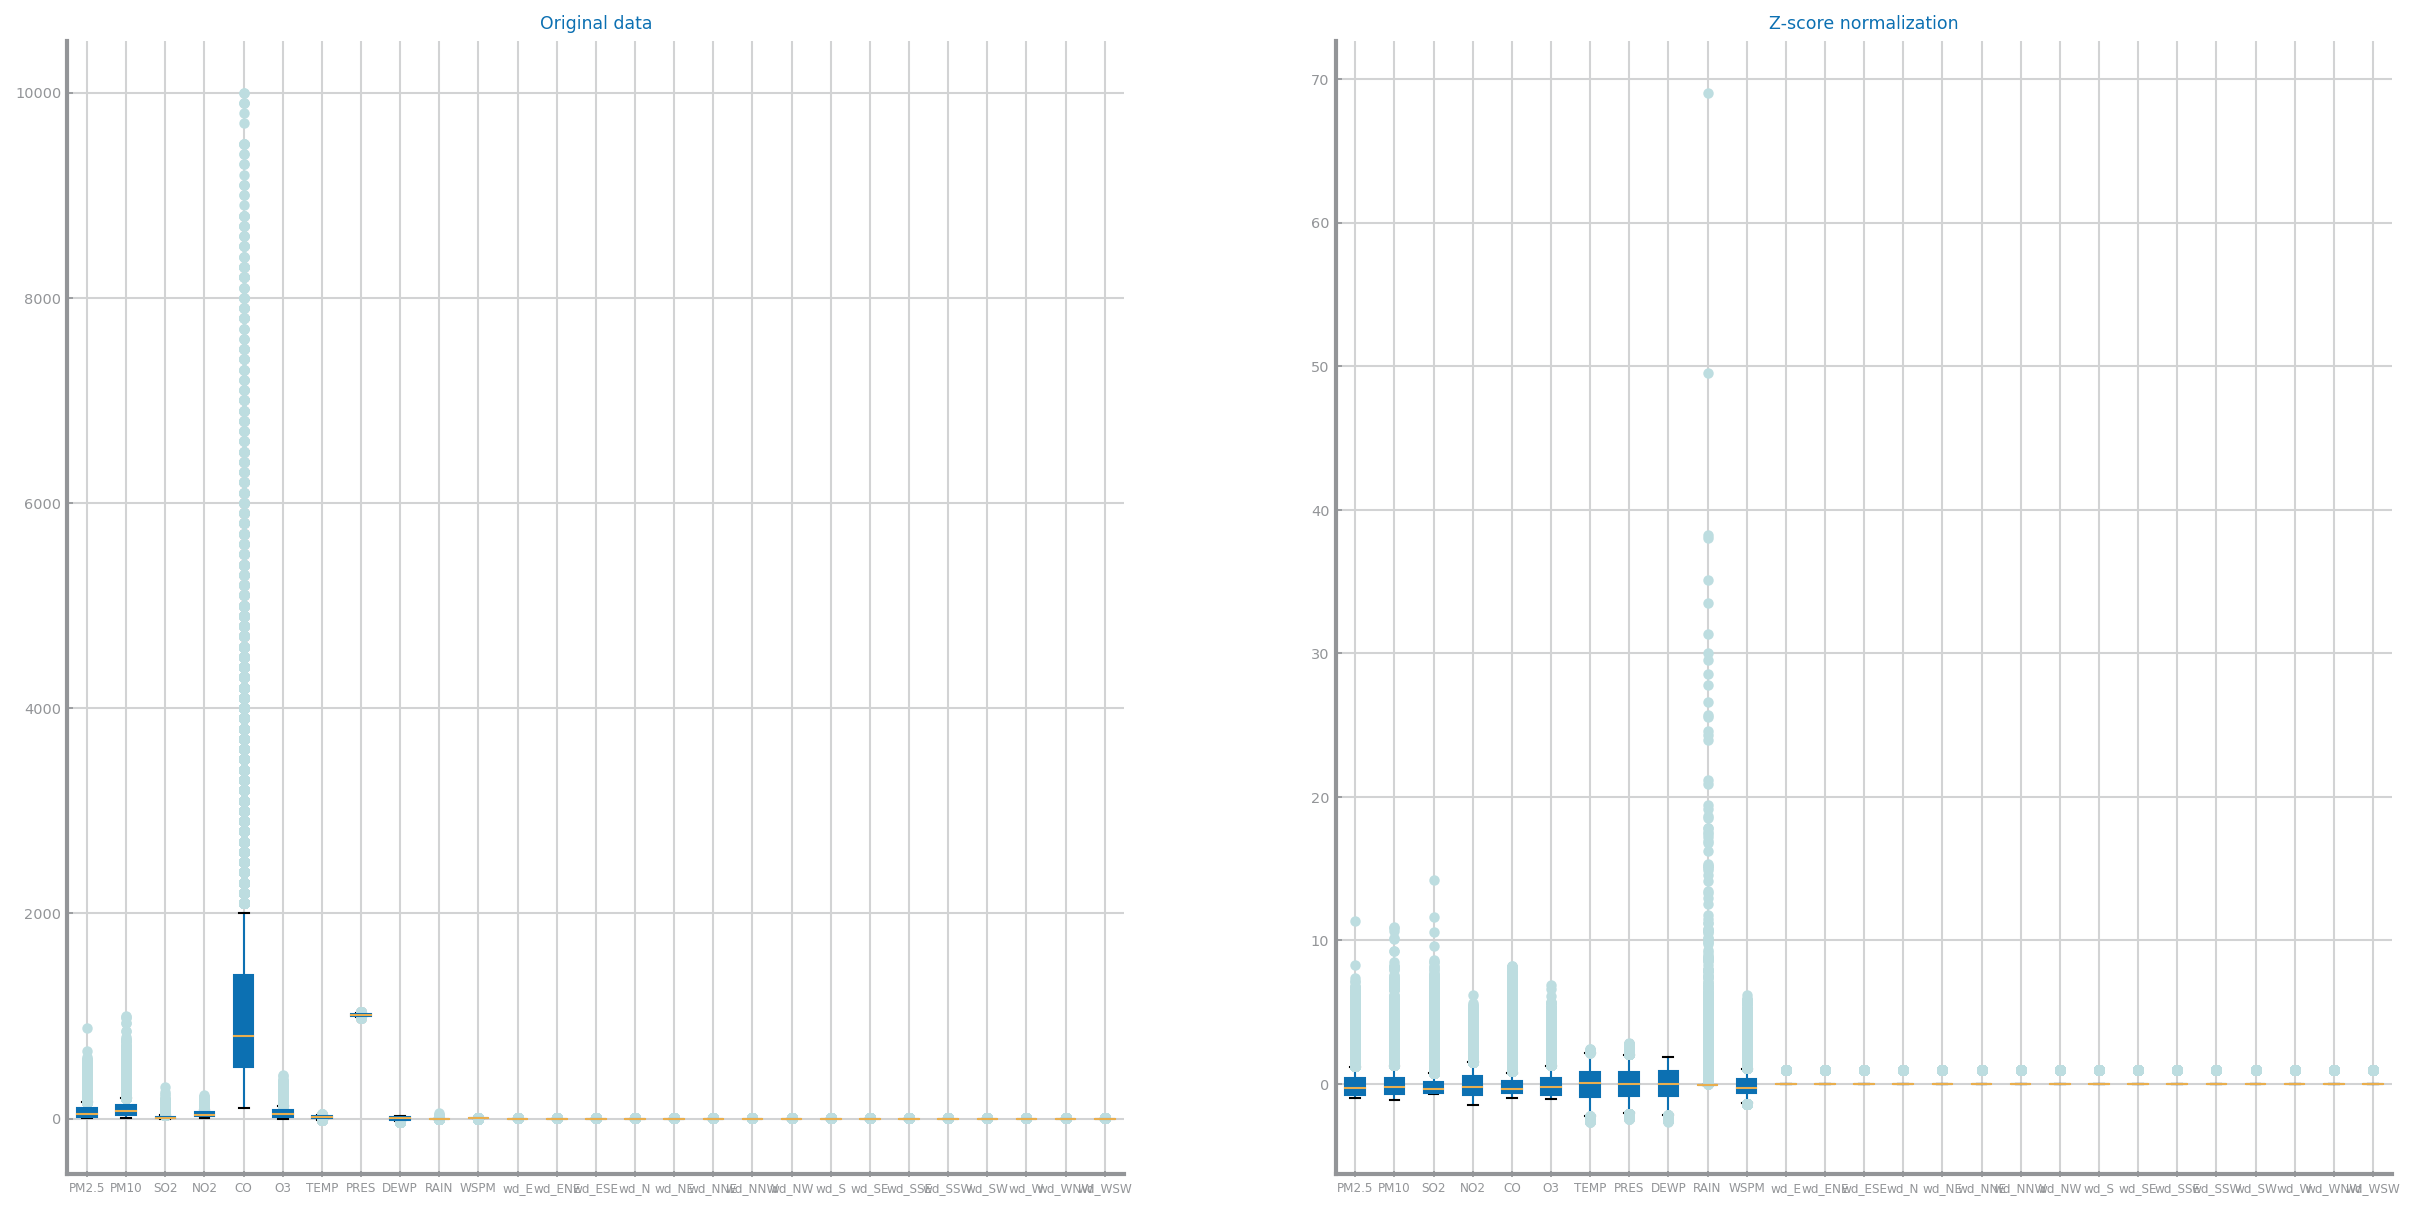

In [65]:
fig, axs = subplots(1, 2, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
data_dummy.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
plt.show()

# Export DataFrame to CSV:

In [66]:
norm_data_zscore.to_csv(project_path + prepared_out_data_file, index=True)